In [1]:
import time
import csv
import pandas as pd
import seaborn as sns; sns.set()
from IPython.display import display, Math, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
import tkinter as tk
from tkinter import filedialog
import os
%matplotlib inline

In [2]:
# Function Definitions

def subtractDataframeColumns(a,b,x,y):
    b.index = a.index
    a['Val_Diff'] = a[y] - b[y]
    return a

def fiberLoader(side, *argv):
    if len(argv) == 0: #No path provided
        root = tk.Tk()
        root.lift()
        root.withdraw()
        scirun_dir = filedialog.askdirectory(title='SCIRun Directory') #Select SCIRun directory
    else:
        scirun_dir = argv[0]
    #return scirun_dir
    amp_files = os.listdir(scirun_dir+'/simulations/Monopolar/'+side+'_Pallidum')
    fiber_names  =[]
    for amp in amp_files:
        amp = amp.split('_amp_')
        fiber_names.append(amp[0])
    fiber_names = np.unique(fiber_names) #only the file names
    
    dir_files = os.listdir(scirun_dir)
    pts = []
    edge = []
    fiber_files = []
    for file in dir_files:
        for name in fiber_names:
            filename = os.path.splitext(file)
            if name == filename[0] and '.edge' in file:
                edge.append(file)
                fiber_files.append(name)
            elif name == filename[0] and '.pts' in file:
                pts.append(file)
            else:
                pass
    return scirun_dir, pts, edge, fiber_files

def fiberActivation(path, pts, edge, ampVal, side):
    fiberActivation = []
    m = np.loadtxt(path+'/'+edge) #edges
    linePoints = np.loadtxt(path+'/'+pts) #pts
    thresh = 0.015
    #thresh = 0.15
    
    # Separate into idividual fibers
    lineCount = 1
    for i in range(1,len(m)):
        if m[i,0] != m[i-1,1]:
            lineCount = lineCount + 1
    lineCount = lineCount + 1
    lineEnd = np.zeros((lineCount))
    
    lineIndex = 0
    lineEnd[lineIndex] = 0
    for i in range(1,len(m)):
        if m[i,0] != m[i-1,1]:
            lineIndex += 1
            lineEnd[lineIndex] = i - 2 + lineIndex + 1
    lineIndex += 1
    lineEnd[lineIndex] = len(linePoints)
    
    for contact in range(4,12):
        for amplitude in range(1,6):
            scale = amplitude
            lineA = pd.read_csv(path+'/simulations/Monopolar/'+side+'_Pallidum/'+ampVal+'_amp_'+str(contact)+'.txt',header=None) #Fiber Current Values
            lineA = np.array(lineA[0])*scale
            max_AF = np.zeros(lineCount-1)
            AFc = np.zeros((len(lineA)))
            ptVal = np.zeros((len(lineA)))
            thresh_loc = np.zeros((len(lineA)))
            thresh_loc[AFc > thresh] = 1
            indexCounter = 0
            for l in range(1,lineCount):
                AF = np.diff(np.diff(lineA[int(lineEnd[l-1]):int(lineEnd[l])]))
                AF[0] = 0
                AF[-1] = 0
                thresh_line = np.zeros(len(AF))
                thresh_line[AF > thresh] = 1
                if len(AF) < 1:
                    AF = [0]
                max_AF[l-1] = max(AF)
                if max(AF) > thresh:
                    ptVal[indexCounter:indexCounter+2+len(AF)] = 1
                    #data = np.ones(len(fiberA))
                    #data = data.tolist()
                    #ptVal.extend(data)
                else:
                    ptVal[indexCounter:indexCounter+2+len(AF)] = 0
                    #data = np.zeros(len(fiberA))
                    #data = data.tolist()
                    #ptVal.extend(data)
                # Concatenate AF matricies for this fiber bundle
                #at current contact/amp
                AFc[indexCounter+1:indexCounter+1+len(AF)] = AF
                thresh_loc[indexCounter+1:indexCounter+1+len(AF)] = thresh_line
                indexCounter += len(AF)+2
            
            percentActivated = len(np.argwhere(max_AF > thresh))/(lineCount-1)*100
            fiberActivation.append(percentActivated)
            lineAmp = lineA
            #np.savetxt(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/PT_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt',ptVal,delimiter=',',fmt='%d')
            #np.savetxt(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/AF_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt',AFc.tolist(),delimiter=',',fmt='%0.6f')
            try:
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/PT_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%d\n' % data for data in ptVal])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/AF_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%.6f\n' % data for data in AFc])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/loc_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%d\n' % data for data in thresh_loc])
            except:
                if contact == 0:
                    os.mkdir(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal)
                os.mkdir(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact))
                
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/PT_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%d\n' % data for data in ptVal])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/AF_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%.6f\n' % data for data in AFc])
                with open(path+'/simulations/mono_fiber_activation/'+side.upper()+'/'+ampVal+'/'+str(contact)+'/loc_'+ampVal+'_'+str(contact)+'_-'+str(amplitude)+'mA.txt', 'w') as file:
                    file.writelines(['%d\n' % data for data in thresh_loc])
                    
    return fiberActivation

#fiberActivation(".","CL_L.pts","CL_L.edge","CLseed_fiberVoltage_Left_","Left")
#fiberLoader('Left')

# Right Side

In [3]:
# Right data

path, pts, edge, ampVal = fiberLoader('Right') #get pts, edge, and SCIRun output files, Right side

percentActivation_Right = []
for f in range(0,len(ampVal)):
    percentActivation_Right = percentActivation_Right + fiberActivation(path,pts[f],edge[f],ampVal[f],'Right')

#df_template_right = pd.read_csv("activation_df_template.csv")
df_template_right = pd.read_csv("activation_df_template_directional.csv")
#df_template_left.head()
df_right = df_template_right
for f in range(0,len(ampVal)):
    if f > 0:
        #df_left.append(df_template_left)
        df_right = pd.concat([df_right, df_template_right], ignore_index=True)
    for i in range(0,40): #Fiber Names
        df_right.loc[i+(40*f), 'Fiber_Name'] = ampVal[f]

df_right.loc[0:len(percentActivation_Right), 'Percent_Activation'] = percentActivation_Right #values

df_right.to_csv(path+'/simulations/activation_Right_pallidum_directional.csv', index=False) #Save to csv

df_right.head()

,Percent_Activation,Contact,Amplitude,Fiber_Name
0,99.0,0,1,Sum_Right_ACC_hdp.100
1,100.0,0,2,Sum_Right_ACC_hdp.100
2,100.0,0,3,Sum_Right_ACC_hdp.100
3,100.0,0,4,Sum_Right_ACC_hdp.100
4,100.0,0,5,Sum_Right_ACC_hdp.100


# Left Side

In [4]:
# Left data

path, pts, edge, ampVal = fiberLoader('Left',path) # Add path to skip dialog box

percentActivation_Left = []
for f in range(0,len(ampVal)):
    percentActivation_Left = percentActivation_Left + fiberActivation(path,pts[f],edge[f],ampVal[f],'Left')
    
    
#df_template_left = pd.read_csv("activation_df_template.csv")
df_template_left = pd.read_csv("activation_df_template_directional.csv")
#df_template_left.head()
df_left = df_template_left
for f in range(0,len(ampVal)):
    if f > 0:
        #df_left.append(df_template_left)
        df_left = pd.concat([df_left, df_template_left], ignore_index=True)
    for i in range(0,40): #Fiber Names
        df_left.loc[i+(40*f), 'Fiber_Name'] = ampVal[f]

#df_template_left.loc[0:len(percentActivation_Left), 'Percent_Activation'] = percentActivation_Left #values
df_left.loc[0:len(percentActivation_Left), 'Percent_Activation'] = percentActivation_Left #values

df_left.to_csv(path+'/simulations/activation_Left_pallidum_directional.csv', index=False) #Save to csv

#df_left = pd.read_csv(path+'/simulations/activation_Left.csv')
df_left.head()

,Percent_Activation,Contact,Amplitude,Fiber_Name
0,17.0,0,1,Sum_Left_ACC_hdp.100
1,92.0,0,2,Sum_Left_ACC_hdp.100
2,100.0,0,3,Sum_Left_ACC_hdp.100
3,100.0,0,4,Sum_Left_ACC_hdp.100
4,100.0,0,5,Sum_Left_ACC_hdp.100


In [5]:
pd.Series(df_left['Fiber_Name']).unique()

array(['Sum_Left_ACC_hdp.100', 'Sum_Left_ansa_lenticularis.500',
       'Sum_Left_dlPFC_hdp.100', 'Sum_Left_dmPFC_hdp.100',
       'Sum_Left_gpe2stn_ass.250', 'Sum_Left_gpe2stn_sm.250',
       'Sum_Left_lenticular_fasciculus.500', 'Sum_Left_M1_hdp_face.100',
       'Sum_Left_M1_hdp_lowerex.100', 'Sum_Left_M1_hdp_upperex.100',
       'Sum_Left_PreMotor_hdp.100', 'Sum_Left_SMA_hdp.100',
       'Sum_Left_vlPFC_hdp.100', 'Sum_Left_vmPFC_hdp.100'], dtype=object)

# Complete Plot

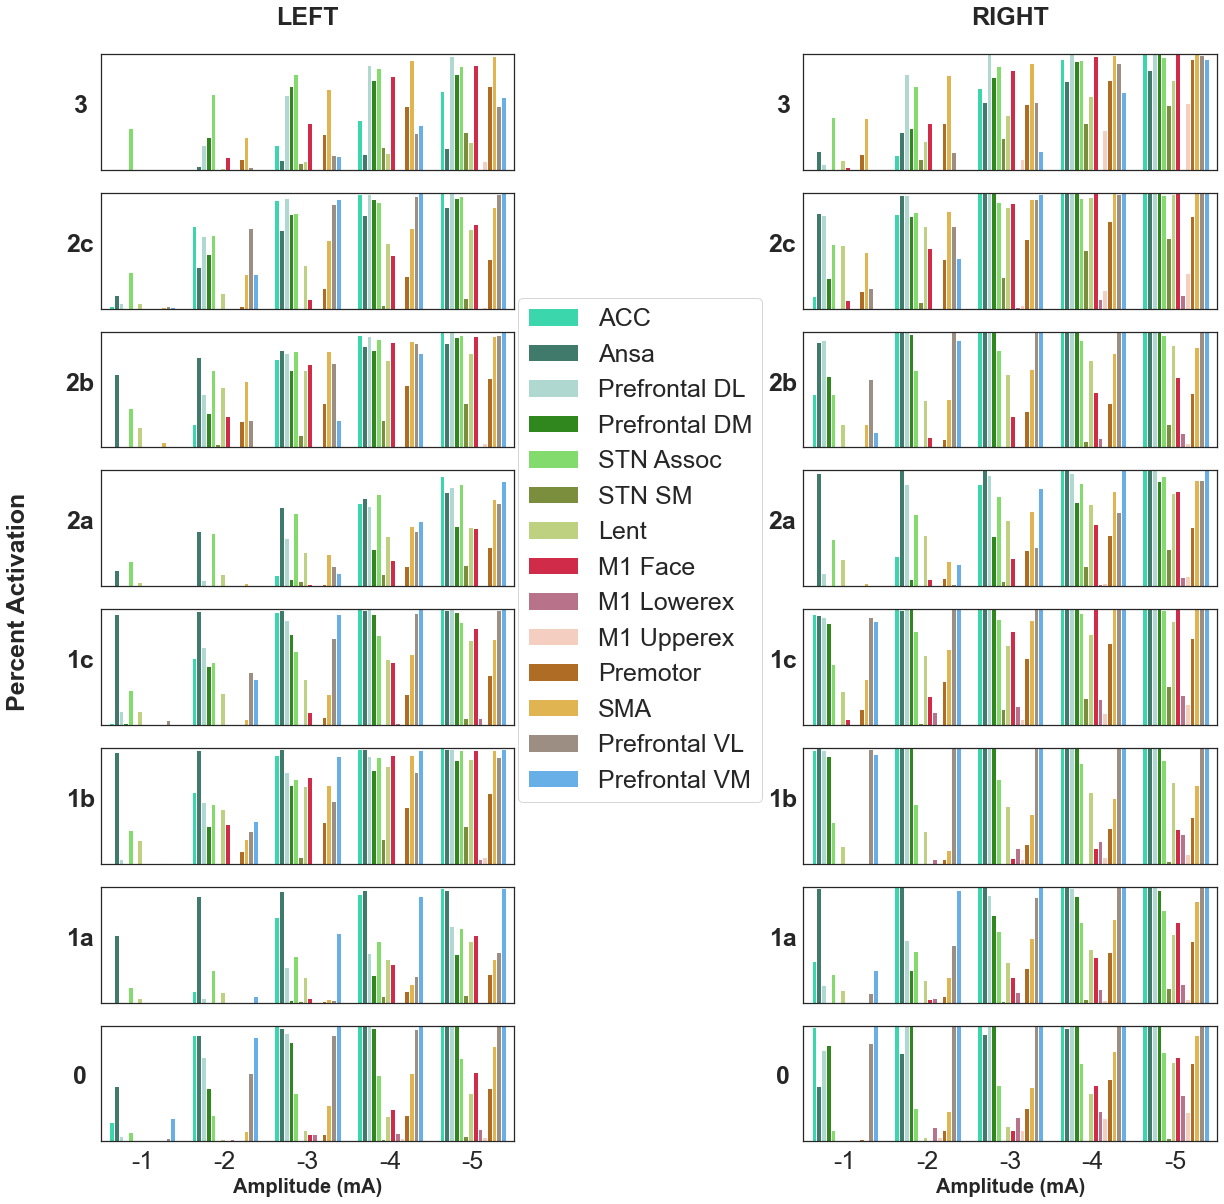

In [6]:
pd.options.mode.chained_assignment = None #hides some annoying warnings (nothing to worry about)
df_left_sub = df_left
df_right_sub = df_right

#Replace fiber names to be more readable
#fibers_old = ['CL_L','CM_L','CM_UF_tracks','MD_L','VPL_L']
fibers_old = pd.Series(df_left['Fiber_Name']).unique()
#fibers_new = ['ACC','M1 Face','M1 Lowerex','M1 Upperex','Premotor','SMA','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','Prefrontal VL','Prefrontal VM'] #change these when you need to
fibers_new = ['ACC','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','M1 Face','M1 Lowerex','M1 Upperex','Premotor','SMA','Prefrontal VL','Prefrontal VM']
#fibers_new = ['ACC','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','Prefrontal VL','Prefrontal VM'] #change these when you need to
count = 0
for fiber_old in fibers_old:
    indices = [i for i, x in enumerate(df_left_sub['Fiber_Name']) if x == fiber_old]
    df_left_sub['Fiber_Name'][indices] = fibers_new[count] #helps set titles in the legend
    df_right_sub['Fiber_Name'][indices] = fibers_new[count]
    count += 1

contact_labels = ['0','1a','1b','1c','2a','2b','2c','3']

plt.rcParams['figure.figsize']=20,20
sns.set(style='white',color_codes=True)

#colors = ["#253494","#F2F275","#2c7fb8","#54DB81","#47D8EA","#FF00CC","#66FF66","#9C51B6","#0081AB"]
#colors = ['#253494', '#F2F275', '#ffb026', '#d55e00', '#47D8EA']
colors = ["#21f0b6", "#35846e", "#a8dfd4", "#23980d", "#78ee5a", "#809b31", "#c5df72", "#eb1138", "#c36785", "#fbcab9", "#c66d0e", "#f9bd3a", "#a08d7f", "#54b2fc"]
fig = plt.figure()
location = [16,14,12,10,8,6,4,2] #subplot locations
cmap = plt.get_cmap("terrain",14) 

for contact in range(0,8,1):
    #print(contact)
    df_left_sub = df_left[df_left['Contact'] == contact]
    df_right_sub = df_right[df_right['Contact'] == contact]
    #contact_name = 'C' + str(contact) #contact labels on y axis
    contact_name = contact_labels[contact]
    #Left Side
    ax = fig.add_subplot(8,2,location[contact]-1)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=[cmap(i) for i in range(14)], data=df_left_sub)
    ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_left_sub)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_left_sub)
    ax.set(ylim=(0, 100))
    ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')
    ax.yaxis.set_label_coords(-0.05,0.45)
    ax.set_xlabel('')
    ax.set_yticks([])
    if contact != 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels([-1,-2,-3,-4,-5],fontsize=25) #amplitude values
        ax.set_xlabel('Amplitude (mA)',fontsize=20,fontweight='bold')
    if contact == 7:
        ax.set_title('LEFT',fontsize=25,y=1.2,fontweight='bold')
        ax.legend(bbox_to_anchor=(1.63,-1),prop={'size':25}) #legend formatting, only 1 is needed
    else:
        ax.legend_.remove()
    
    #Right Side
    ax = fig.add_subplot(8,2,location[contact])
    ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_right_sub)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_right_sub)
    ax.set(ylim=(0, 100))
    ax.legend_.remove()
    ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')  
    ax.yaxis.set_label_coords(-0.05,0.45)
    ax.set_xlabel('')
    ax.set_yticks([])
    if contact != 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels([-1,-2,-3,-4,-5],fontsize=25)
        ax.set_xlabel('Amplitude (mA)',fontsize=20,fontweight='bold')
    if contact == 7:
        ax.set_title('RIGHT',fontsize=25,y=1.2,fontweight='bold')

plt.subplots_adjust(wspace=0.7) #give more space between the plots   
fig.text(0.06,0.5,'Percent Activation',va = 'center',rotation='vertical',fontsize=25,fontweight='bold')
plt.show()

## Difference Between Segments

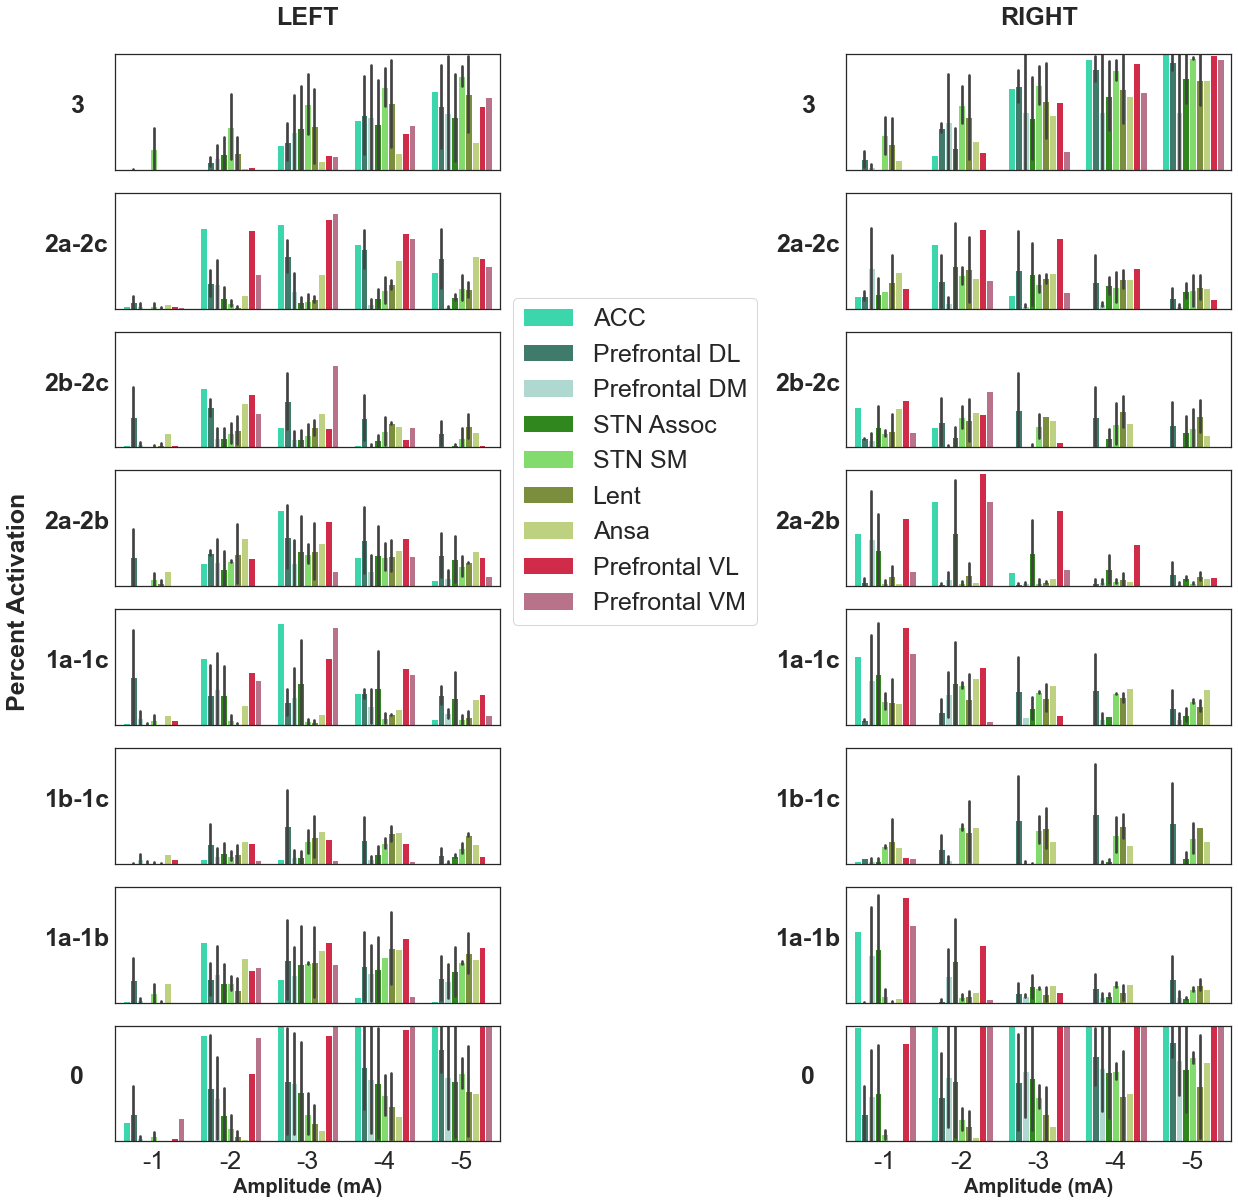

In [7]:
pd.options.mode.chained_assignment = None #hides some annoying warnings (nothing to worry about)
df_left_sub = df_left
df_right_sub = df_right

#Replace fiber names to be more readable
#fibers_old = ['CL_L','CM_L','CM_UF_tracks','MD_L','VPL_L']
fibers_old = pd.Series(df_left['Fiber_Name']).unique()
fibers_new = ['ACC','M1 Face','M1 Lowerex','M1 Upperex','Premotor','SMA','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','Prefrontal VL','Prefrontal VM'] #change these when you need to
#fibers_new = ['ACC','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','Prefrontal VL','Prefrontal VM'] #change these when you need to
count = 0
for fiber_old in fibers_old:
    indices = [i for i, x in enumerate(df_left_sub['Fiber_Name']) if x == fiber_old]
    df_left_sub['Fiber_Name'][indices] = fibers_new[count] #helps set titles in the legend
    df_right_sub['Fiber_Name'][indices] = fibers_new[count]
    count += 1

contact_labels = ['0','1a-1b','1b-1c','1a-1c','2a-2b','2b-2c','2a-2c','3']

plt.rcParams['figure.figsize']=20,20
sns.set(style='white',color_codes=True)

#colors = ["#253494","#F2F275","#2c7fb8","#54DB81","#47D8EA","#FF00CC","#66FF66","#9C51B6","#0081AB"]
#colors = ['#253494', '#F2F275', '#ffb026', '#d55e00', '#47D8EA']
colors = ["#21f0b6", "#35846e", "#a8dfd4", "#23980d", "#78ee5a", "#809b31", "#c5df72", "#eb1138", "#c36785", "#fbcab9", "#c66d0e", "#f9bd3a", "#a08d7f", "#54b2fc"]
fig = plt.figure()
location = [16,14,12,10,8,6,4,2] #subplot locations
cmap = plt.get_cmap("terrain",14)

for contact in range(0,8,1):
    #print(contact)
    df_left_sub = df_left[df_left['Contact'] == contact]
    df_right_sub = df_right[df_right['Contact'] == contact]
    if (contact > 0 and contact < 3) or (contact > 3 and contact < 6):
        df_left_sub.loc[:,"Percent_Activation"] = abs(df_left[df_left['Contact'] == contact]["Percent_Activation"].to_numpy() - df_left[df_left['Contact'] == contact+1]["Percent_Activation"].to_numpy())
        df_right_sub.loc[:,"Percent_Activation"] = abs(df_right[df_right['Contact'] == contact]["Percent_Activation"].to_numpy() - df_right[df_right['Contact'] == contact+1]["Percent_Activation"].to_numpy())
    elif contact == 3 or contact == 6:
        df_left_sub.loc[:,"Percent_Activation"] = abs(df_left[df_left['Contact'] == contact]["Percent_Activation"].to_numpy() - df_left[df_left['Contact'] == contact+1]["Percent_Activation"].to_numpy())
        df_right_sub.loc[:,"Percent_Activation"] = abs(df_right[df_right['Contact'] == contact-2]["Percent_Activation"].to_numpy() - df_right[df_right['Contact'] == contact]["Percent_Activation"].to_numpy())
    #contact_name = 'C' + str(contact) #contact labels on y axis
    contact_name = contact_labels[contact]
    #Left Side
    ax = fig.add_subplot(8,2,location[contact]-1)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=[cmap(i) for i in range(14)], data=df_left_sub)
    ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_left_sub)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_left_sub)
    ax.set(ylim=(0, 100))
    ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')
    ax.yaxis.set_label_coords(-0.1,0.45)
    ax.set_xlabel('')
    ax.set_yticks([])
    if contact != 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels([-1,-2,-3,-4,-5],fontsize=25) #amplitude values
        ax.set_xlabel('Amplitude (mA)',fontsize=20,fontweight='bold')
    if contact == 7:
        ax.set_title('LEFT',fontsize=25,y=1.2,fontweight='bold')
        ax.legend(bbox_to_anchor=(1.7,-1),prop={'size':25}) #legend formatting, only 1 is needed
    else:
        ax.legend_.remove()
    
    #Right Side
    ax = fig.add_subplot(8,2,location[contact])
    ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_right_sub)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_right_sub)
    ax.set(ylim=(0, 100))
    ax.legend_.remove()
    ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')  
    ax.yaxis.set_label_coords(-0.1,0.45)
    ax.set_xlabel('')
    ax.set_yticks([])
    if contact != 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels([-1,-2,-3,-4,-5],fontsize=25)
        ax.set_xlabel('Amplitude (mA)',fontsize=20,fontweight='bold')
    if contact == 7:
        ax.set_title('RIGHT',fontsize=25,y=1.2,fontweight='bold')

plt.subplots_adjust(wspace=0.9) #give more space between the plots   
fig.text(0.05,0.5,'Percent Activation',va = 'center',rotation='vertical',fontsize=25,fontweight='bold')
plt.show()

## Ring vs Directional

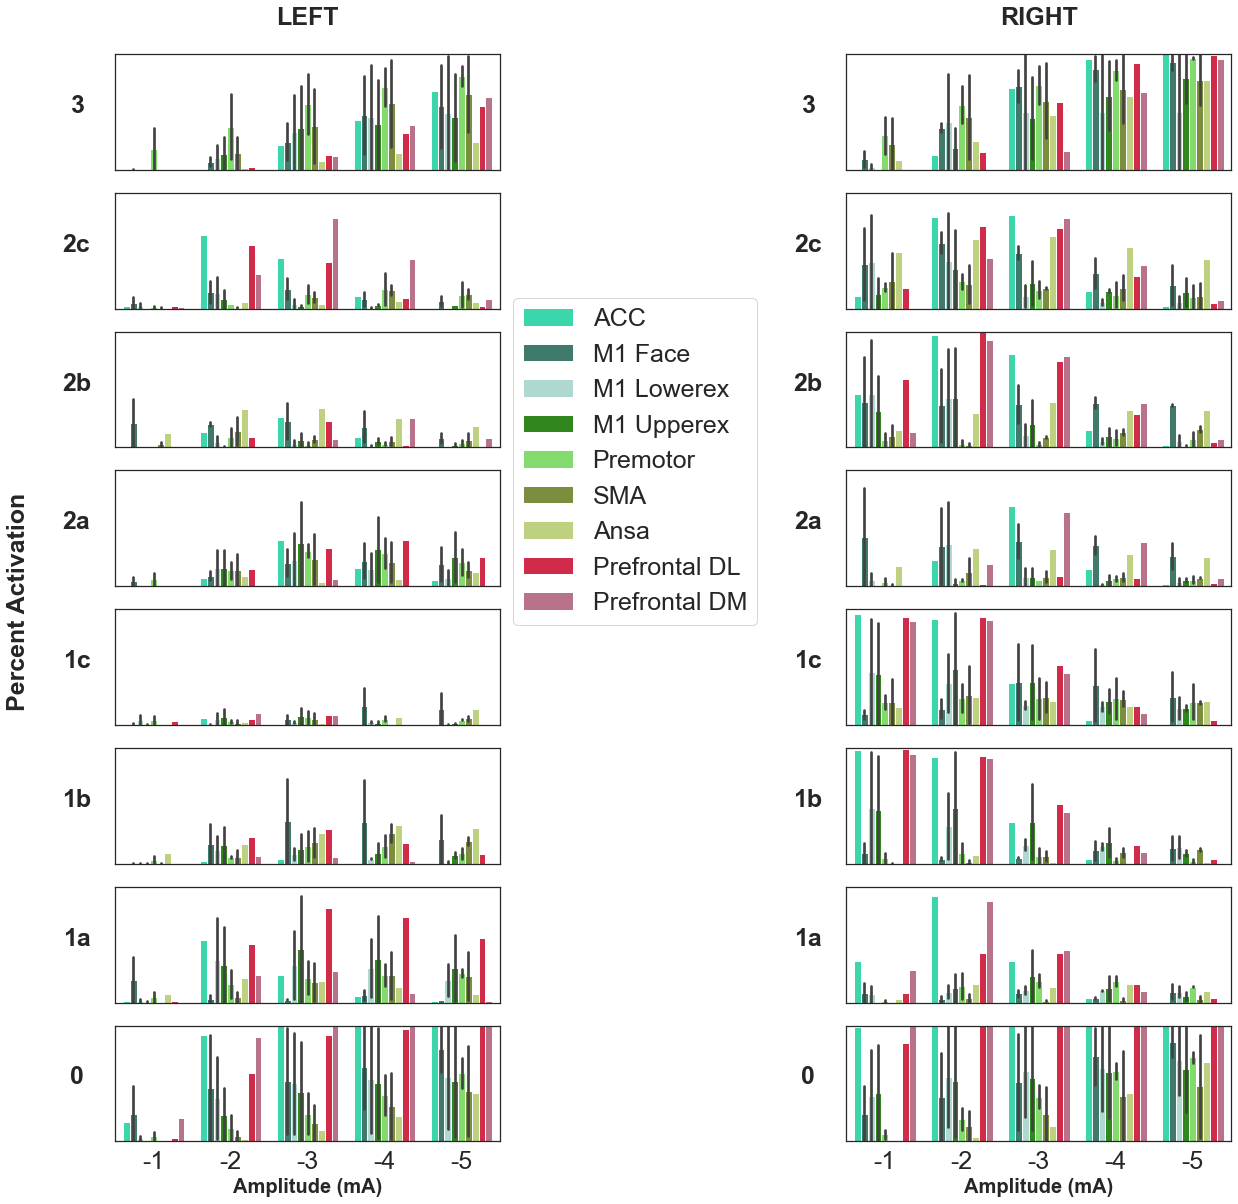

In [8]:
df_left_ring = pd.read_csv(path+'/simulations/activation_Left_pallidum_ring.csv')
df_right_ring = pd.read_csv(path+'/simulations/activation_Right_pallidum_ring.csv')

pd.options.mode.chained_assignment = None #hides some annoying warnings (nothing to worry about)
df_left_sub = df_left
df_right_sub = df_right

#Replace fiber names to be more readable
#fibers_old = ['CL_L','CM_L','CM_UF_tracks','MD_L','VPL_L']
fibers_old = pd.Series(df_left['Fiber_Name']).unique()
fibers_new = ['ACC','M1 Face','M1 Lowerex','M1 Upperex','Premotor','SMA','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','Prefrontal VL','Prefrontal VM'] #change these when you need to
#fibers_new = ['ACC','Ansa','Prefrontal DL','Prefrontal DM','STN Assoc','STN SM','Lent','Prefrontal VL','Prefrontal VM'] #change these when you need to
count = 0
for fiber_old in fibers_old:
    indices = [i for i, x in enumerate(df_left_sub['Fiber_Name']) if x == fiber_old]
    df_left_sub['Fiber_Name'][indices] = fibers_new[count] #helps set titles in the legend
    df_right_sub['Fiber_Name'][indices] = fibers_new[count]
    count += 1

contact_labels = ['0','1a','1b','1c','2a','2b','2c','3']

plt.rcParams['figure.figsize']=20,20
sns.set(style='white',color_codes=True)

#colors = ["#253494","#F2F275","#2c7fb8","#54DB81","#47D8EA","#FF00CC","#66FF66","#9C51B6","#0081AB"]
#colors = ['#253494', '#F2F275', '#ffb026', '#d55e00', '#47D8EA']
colors = ["#21f0b6", "#35846e", "#a8dfd4", "#23980d", "#78ee5a", "#809b31", "#c5df72", "#eb1138", "#c36785", "#fbcab9", "#c66d0e", "#f9bd3a", "#a08d7f", "#54b2fc"]
fig = plt.figure()
location = [16,14,12,10,8,6,4,2] #subplot locations
cmap = plt.get_cmap("terrain",14)

for contact in range(0,8,1):
    #print(contact)
    df_left_sub = df_left[df_left['Contact'] == contact]
    df_right_sub = df_right[df_right['Contact'] == contact]
    if contact > 0 and contact < 4:
        df_left_sub.loc[:,"Percent_Activation"] = abs(df_left_ring[df_left_ring['Contact'] == 1]["Percent_Activation"].to_numpy() - df_left[df_left['Contact'] == contact]["Percent_Activation"].to_numpy())
        df_right_sub.loc[:,"Percent_Activation"] = abs(df_right_ring[df_right_ring['Contact'] == 1]["Percent_Activation"].to_numpy() - df_right[df_right['Contact'] == contact]["Percent_Activation"].to_numpy())
    elif contact >= 4 and contact < 7:
        df_left_sub.loc[:,"Percent_Activation"] = abs(df_left_ring[df_left_ring['Contact'] == 2]["Percent_Activation"].to_numpy() - df_left[df_left['Contact'] == contact]["Percent_Activation"].to_numpy())
        df_right_sub.loc[:,"Percent_Activation"] = abs(df_right_ring[df_right_ring['Contact'] == 2]["Percent_Activation"].to_numpy() - df_right[df_right['Contact'] == contact]["Percent_Activation"].to_numpy())
    #contact_name = 'C' + str(contact) #contact labels on y axis
    contact_name = contact_labels[contact]
    #Left Side
    ax = fig.add_subplot(8,2,location[contact]-1)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=[cmap(i) for i in range(14)], data=df_left_sub)
    ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_left_sub)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_left_sub)
    ax.set(ylim=(0, 100))
    ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')
    ax.yaxis.set_label_coords(-0.1,0.45)
    ax.set_xlabel('')
    ax.set_yticks([])
    if contact != 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels([-1,-2,-3,-4,-5],fontsize=25) #amplitude values
        ax.set_xlabel('Amplitude (mA)',fontsize=20,fontweight='bold')
    if contact == 7:
        ax.set_title('LEFT',fontsize=25,y=1.2,fontweight='bold')
        ax.legend(bbox_to_anchor=(1.7,-1),prop={'size':25}) #legend formatting, only 1 is needed
    else:
        ax.legend_.remove()
    
    #Right Side
    ax = fig.add_subplot(8,2,location[contact])
    ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", palette=colors, data=df_right_sub)
    #ax = sns.barplot(x="Amplitude", y="Percent_Activation", hue="Fiber_Name", data=df_right_sub)
    ax.set(ylim=(0, 100))
    ax.legend_.remove()
    ax.set_ylabel(contact_name,fontsize=25,rotation=0,fontweight='bold')  
    ax.yaxis.set_label_coords(-0.1,0.45)
    ax.set_xlabel('')
    ax.set_yticks([])
    if contact != 0:
        ax.set_xticks([])
    else:
        ax.set_xticklabels([-1,-2,-3,-4,-5],fontsize=25)
        ax.set_xlabel('Amplitude (mA)',fontsize=20,fontweight='bold')
    if contact == 7:
        ax.set_title('RIGHT',fontsize=25,y=1.2,fontweight='bold')

plt.subplots_adjust(wspace=0.9) #give more space between the plots   
fig.text(0.05,0.5,'Percent Activation',va = 'center',rotation='vertical',fontsize=25,fontweight='bold')
plt.show()